## PyTorch CEA model
Based on this code: https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb

In [1]:
import time
import types

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchsummary import summary

from logger import TBLogger

%load_ext autoreload
%autoreload 2

In [2]:
debug_vals = types.SimpleNamespace()

### Load Data

In [3]:
from matplotlib.image import imread
from extract_patches import *

In [4]:
img_name = 'ESP_011304_1825_RED2_0.IMG'
images, ids = extract_patches_from_img(img_name, patch_size=256)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(img):
    plt.imshow(np.squeeze(img))

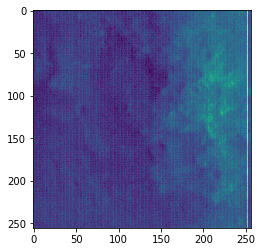

In [6]:
imshow(images[0])

In [7]:
from pytorch_utils import *

tensor_images = numpy_images_to_tensor_dataset(images)

# converting to range 0..1 so it can be decoded by sigmoid activation
tensor_images = tensor_images / 255

In [8]:
tensor_images.size()

torch.Size([784, 1, 256, 256])

In [52]:
batch_size = 16

dataset = torch.utils.data.TensorDataset(tensor_images, tensor_images)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [10]:
try:
    # we need it because of cuda bug:
    # https://github.com/pytorch/pytorch/issues/17108
    _ = torch.cuda.current_device()
except:
    pass

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Model

In [11]:
class ConvAutoencoderV2(nn.Module):
    def __init__(self, image_channels=1):
        super(ConvAutoencoderV2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 5, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            
            nn.Conv2d(5, 10, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            
            nn.Conv2d(10, 15, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            
            nn.Conv2d(15, 20, kernel_size=5, stride=2, padding=2),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(20, 15, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(15, 10, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(10, 5, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(5, image_channels, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(100, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

model = ConvAutoencoderV2().to(device)
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 128, 128]             130
              ReLU-2          [-1, 5, 128, 128]               0
            Conv2d-3           [-1, 10, 64, 64]           1,260
              ReLU-4           [-1, 10, 64, 64]               0
            Conv2d-5           [-1, 15, 32, 32]           3,765
              ReLU-6           [-1, 15, 32, 32]               0
            Conv2d-7           [-1, 20, 16, 16]           7,520
              ReLU-8           [-1, 20, 16, 16]               0
   ConvTranspose2d-9           [-1, 15, 32, 32]           4,815
             ReLU-10           [-1, 15, 32, 32]               0
  ConvTranspose2d-11           [-1, 10, 64, 64]           2,410
             ReLU-12           [-1, 10, 64, 64]               0
  ConvTranspose2d-13          [-1, 5, 128, 128]             805
             ReLU-14          [-1, 5, 1

In [70]:
from lr_finder import LRFinder

learning_rate = 1e-3
num_epochs = 40

criterion = nn.MSELoss()

# reseting the model
model = ConvAutoencoderV2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)
lr_finder = LRFinder(model, optimizer, criterion, device="cpu")

lr_finder.range_test(loader, end_lr=10, num_iter=num_epochs, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


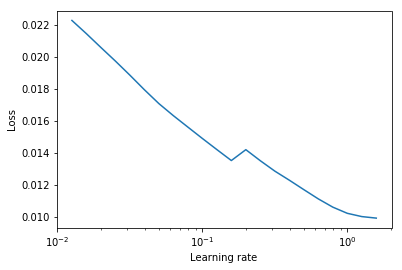

In [71]:
lr_finder.plot()

In [55]:
lr_finder.reset()

In [28]:
mean_losses = []

logdir = './logs/conv_autoencoder_v2_run_4'
tb_logger = TBLogger(logdir)

def train_model():
    model.train()

    for epoch in range(num_epochs):
        losses = []
        
        for i, (data,) in enumerate(loader):
            data = data.to(device)

            # forward
            output = model(data)

            # compute MSE loss
            loss = criterion(output, data)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
        
        mean_loss = np.mean(losses)
        mean_losses.append(mean_loss)
        
        # log to file on every epoch
        tb_logger.log_loss(mean_loss, epoch)
        
        # log to console from time to time
        if epoch % 10 == 0:
            print(time.strftime('%X') + ' - epoch [{}/{}], loss:{:.8f}'.format(epoch+1, num_epochs, mean_loss))
            
            # also save the model
            torch.save(model.state_dict(), f'{logdir}/conv_autoencoder_v2_e_{epoch}.pth')
            
            save_test_img(f'{logdir}/e_{epoch}_image.png', model)

    torch.save(model.state_dict(), './conv_autoencoder_v4.pth')

def save_test_img(fname, model):
    test_data = tensor_images[5:6]
    test_data = test_data.to(device)

    # forward
    test_output = model(test_data)
    
    plt.imsave(fname, np.squeeze(test_output.data.cpu().numpy()))

mean_losses = []
train_model()

# close logger
tb_logger.close()
print('DONE')

00:54:03 - epoch [1/20], loss:0.00429553
00:57:21 - epoch [11/20], loss:0.00023642
DONE


In [14]:
torch.save(model.state_dict(), './conv_autoencoder_v5.pth')

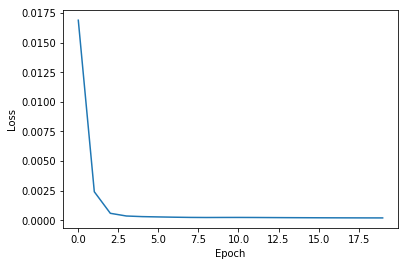

In [15]:
plt.plot(mean_losses[:])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Test

In [16]:
def test_model(img):
    model.eval()
    test_data = img
    test_data = test_data.to(device)

    # forward
    test_output = model(test_data)

    # a = test_output.data
    imshow(test_output.data.cpu().numpy())

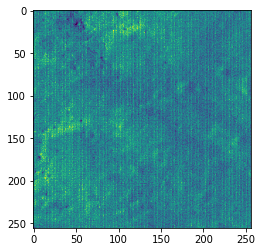

In [17]:
# model = ConvAutoencoderV2().to(device)
imshow(tensor_images[5:6])

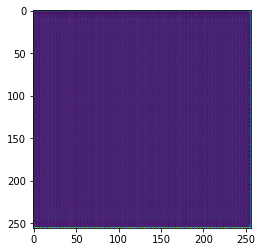

In [18]:
test_model(tensor_images[5:6])

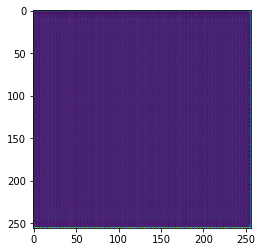

In [19]:
test_model(tensor_images[5:6])

### Training speed
It took 20 mins to run 1 epoch on all patches(~100 batches)

**~12 seconds per batch**